# Feature Selection Using Random Noise

The ability to filter out unnecessary features is an important task in ML. By simplifying the feature space, it helps the ML process in various ways. Some benefits of simplifying the feature space include:
* Reduction of computation time.
* Reduction of the size of the dataset during storage.
* Removal of redundant features.
* Simplification of the data pipeline.

In this notebook, we'll go over a simple method to reduce the feature space using a random gaussian feature and permutation importance.

Before we begin, let's import the necessary libraries for this exercise.

In [ ]:
from sklearn import datasets
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.inspection import permutation_importance
import pandas as pd

Next, we'll import the popular diabetes dataset using SKlearn. I prefer this dataset because it doesn't require extra preprocessing.

In [ ]:
X, y = datasets.load_diabetes(return_X_y=True, as_frame=True)

This is where, using NumPy, we'll make our random column. We'll name it 'random' and treat it as another feature in our dataset.

The idea here is, because it's a random feature, it doesn't contribute to the model prediction. We're intentionally adding random noise. With the help of permutation importance, this will help us determine which features to exclude later.

In [ ]:
X = X.assign(
        random = np.random.normal(size=X.shape[0])
    )

Nothing fancy happening here. We'll split the data as train/test for later evaluation.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

We're going to use random forest for this exercise, because it's easy and doesn't require the features to be normalized/standardized.

In [ ]:
rf = RandomForestRegressor()

We fit our model.

In [ ]:
rf.fit(X_train, y_train)

RandomForestRegressor()

And we score it on the test set.

In [ ]:
rf.score(X_test, y_test)

0.4856244017023714

Now it's time to look at the feature importances. We'll use the model agnostic method, permutation importance, to help us with this. (In case you're wondering how permutation importance works, check out my article on it: https://github.com/AkmelSyed/Coding-Permutation-Importance-from-Scratch/blob/main/Coding%20Permutation%20Importance%20from%20Scratch.ipynb).

In [ ]:
result = permutation_importance(
    rf, X_test, y_test, n_repeats=100, random_state=42
)

To help us plot our feature importances, we'll make a small function (I stole it off SKlearn's website).

In [ ]:
def plot_permutation_importance(perm_dict, X, title):
    sorted_importances_idx = perm_dict['importances_mean'].argsort()
    importances = pd.DataFrame(
        perm_dict['importances'][sorted_importances_idx].T,
        columns=X.columns[sorted_importances_idx],
    )
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title(title)
    ax.axvline(x=0, color="k", linestyle="--")
    ax.set_xlabel('Decrease in accuracy score')
    ax.figure.tight_layout()

And here's our feature importances plot.

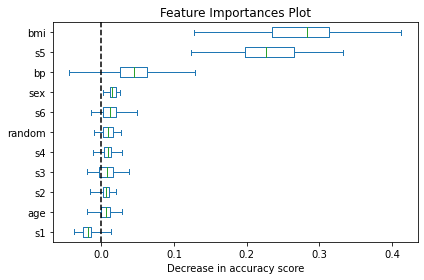

In [ ]:
plot_permutation_importance(result, X_test, 'Feature Importances Plot')

We see our 'random' feature has a higher average influence than some features. We also see that the top of the whisker for the random feature encompasses the average influence values for all features which are not 'bmi', 's5' and 'bp'.

What we'll do is remove all the features except those 3.

Let's retrain our model.

In [ ]:
keep_cols = ['bmi', 's5', 'bp']
rf.fit(X_train[keep_cols], y_train)

RandomForestRegressor()

And surprise, our model performs just as well with only 3 features.

In [ ]:
rf.score(X_test[keep_cols], y_test)

0.47410104592443747